# Lightkurve for Spitzer

The lightkurve framework was designed for Kepler/K2 and TESS missions, which natively provide localized 3D datacubes in the form of Target Pixel Files (TPFs).  Other missions generally do not provide such a data product.  

Lightkurve has recently introduce the ability to make TPFs for missions beyond Kepler/K2 or TESS, so long as the data are housed as a consecutive sequence of individual 2D fits images, and possessing certain standard metadata keywords.  In this tutorial we demonstrate using lightkurve for the Spitzer mission.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import lightkurve as lk

In [3]:
lk.__version__

'1.5.dev'

### Wait, Spitzer makes lightcurves?   

Yes, Spitzer targeted certain science cases with point-and-stare photometry for up to days or weeks on end.  Brown Dwarfs, for example, are impossibly faint to observe in the visible wavelength bands, so sensitive mid-infrared observations are necessary to measure clouds.

### Programmatically download the data

The Spitzer data are stored at the [Spitzer Heritage Archive (SHA)](https://sha.ipac.caltech.edu/applications/Spitzer/SHA/) rather than MAST, so the traditional lightkurve `search` features will not work.  Astroquery provides an experimental programmatic interface to the SHA.

In [4]:
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery import sha

/Users/obsidian/anaconda3/envs/lightkurve_base/lib/python3.6/site-packages/astroquery/sha/__init__.py:14: UserWarning: Experimental: SHA has not yet been refactored to have its API match the rest of astroquery.
  warnings.warn("Experimental: SHA has not yet been refactored to have its "


Let's pick a brown dwarf target that has a conspicuous sine wave as seen in Figure 5 of [Metchev et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...799..154M/abstract).

In [5]:
coord = SkyCoord.from_name('2MASS J22282889-4310262')

This and other targets often have many repeated visits, analogous to campaigns.  We'll first query for the "mosaic" images to gauge which observations have the most data available, constructing a makeshift **observing log**.  Not all observing modes have the mosaic images available.

In [6]:
sha_result = sha.query(ra=coord.ra.value, dec=coord.dec.value,size=0.05, dataset=2)

In [7]:
df_sha = sha_result.to_pandas().drop(columns=['ptcomment', 'heritagefilename'])
byte_mask = df_sha.iloc[0].apply(lambda col: type(col) == bytes).to_dict()

for col in df_sha.columns:
    if byte_mask[col]:
        df_sha[col] = df_sha[col].str.decode("utf-8").str.strip()
        
    if col in ['begintime', 'endtime']:
        df_sha[col] = pd.to_datetime(df_sha[col])

Let's just keep the data obtained in `IRAC Map PC` mode, one of Spitzer's most popular for time series.

In [8]:
df_sha = df_sha[df_sha.modedisplayname=='IRAC Map PC'].reset_index(drop=True)

In [9]:
df_sha['obs_duration_hours'] = (df_sha['endtime'] - df_sha['begintime']).apply(lambda dt: dt.seconds/3600.0)

msg = "This source has {:0.1f} hours of Spitzer observations, with a single visit maximum of {:.1f} hours."
msg.format(df_sha['obs_duration_hours'].sum(), df_sha['obs_duration_hours'].max())

'This source has 57.8 hours of Spitzer observations, with a single visit maximum of 4.1 hours.'

In [10]:
obs_log = df_sha[['reqkey', 'modedisplayname', 'wavelength', 'begintime', 'obs_duration_hours']].sort_values('begintime')
obs_log = obs_log[obs_log.modedisplayname == 'IRAC Map PC'].reset_index(drop=True)
obs_log.groupby('wavelength').obs_duration_hours.sum()

wavelength
IRAC 3.6um    45.642500
IRAC 4.5um    12.116944
Name: obs_duration_hours, dtype: float64

In [11]:
obs_log.tail(10)

,reqkey,modedisplayname,wavelength,begintime,obs_duration_hours
24,46352640,IRAC Map PC,IRAC 3.6um,2013-07-23 15:06:46,3.530000
25,46352896,IRAC Map PC,IRAC 4.5um,2013-07-23 18:43:26,2.128889
26,46352384,IRAC Map PC,IRAC 3.6um,2013-07-23 20:56:04,2.129167
27,46349056,IRAC Map PC,IRAC 3.6um,2013-07-27 05:59:50,0.418611
28,46353408,IRAC Map PC,IRAC 3.6um,2013-07-27 06:29:55,3.530000
29,46353152,IRAC Map PC,IRAC 3.6um,2013-07-27 12:19:15,2.420000
30,46323200,IRAC Map PC,IRAC 3.6um,2013-07-29 03:06:07,0.418611
31,46354176,IRAC Map PC,IRAC 3.6um,2013-07-29 03:36:11,3.530000
32,46354432,IRAC Map PC,IRAC 4.5um,2013-07-29 07:12:52,2.128889
33,46353920,IRAC Map PC,IRAC 3.6um,2013-07-29 09:25:31,4.123333


You can either pick a reqkey or get the one with the maximum observing window.

In [12]:
reqkey = df_sha.iloc[df_sha['obs_duration_hours'].idxmax()].reqkey

Now query by the request key, and get each individual frame with calibrated products.  These are stored as zip files.

In [13]:
from glob import glob
from tqdm import tqdm
import zipfile
import os

In [14]:
%%time
sha_result_all = sha.query(reqkey=reqkey, dataset=1)

CPU times: user 99.4 ms, sys: 15.6 ms, total: 115 ms
Wall time: 4.42 s


In [15]:
sha_result_all.sort(keys='externalname') # Has the effect of sorting by time!

In [16]:
n_files = len(sha_result_all)
out_dir ='./spitzer_data/'
os.makedirs(out_dir, exist_ok=True)

In [17]:
for ii in tqdm(range(n_files), total=n_files):
    url = sha_result_all['accessWithAnc1Url'][ii].strip()
    out_name ='SHA_{:09d}_{:05d}'.format(reqkey,ii)
    file_name = out_dir+out_name+'.zip'
    if not os.path.exists(file_name):
        sha.save_file(url, out_dir=out_dir, out_name=out_name)
        
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(out_dir)

100%|██████████| 1133/1133 [08:22<00:00,  2.25it/s]


Split the files into Calibrated target frames and their uncertainties.

In [18]:
base_path = 'spitzer_data/r{}/ch1/'.format(reqkey) #for IRAC1
clean_fns = sorted(glob(base_path+'**/*cbcd.fits', recursive=True))
unc_fns = sorted(glob(base_path+'**/*cbunc.fits', recursive=True))

## Cut out Spitzer TPFs from lightkurve 

Now we can turn these lists of individual fits files into a 3D data cube with the TargetPixelFile format.

In [19]:
size=(21,21)

In [20]:
tpf = lk.factory.TargetPixelFileFactory.from_fits_images(images=clean_fns, position=coord,size=size, 
                                          extension=0, targetid='ch1')

100%|██████████| 1131/1131 [01:08<00:00, 16.42it/s]


In [21]:
tpf_unc = lk.factory.TargetPixelFileFactory.from_fits_images(images=unc_fns,position=coord,size=size, 
                                          extension=0, targetid='ch1')

100%|██████████| 1131/1131 [01:07<00:00, 16.82it/s]


Spitzer saves its uncertainty files as separate fits files.  As a workaround, we can treat the uncertainty slices as their own TPF, then override the `FLUX_ERR` attribute in the next line:

In [22]:
tpf.hdu[1].data['FLUX_ERR'] = tpf_unc.flux

We'll save the fits file to its own TPF, making it faster to read-in later, *e.g.* `tpf = lk.TargetPixelFile('2M_J2228-4310.fits')`.

In [23]:
tpf.to_fits(output_fn='2M_J2228-4310.fits', overwrite=True)

We have an 1131 cadence TPF, with $xy$ dimensions $21\times21$.

In [24]:
tpf.shape

(1131, 21, 21)

In [25]:
aperture_mask=tpf.create_threshold_mask(3)

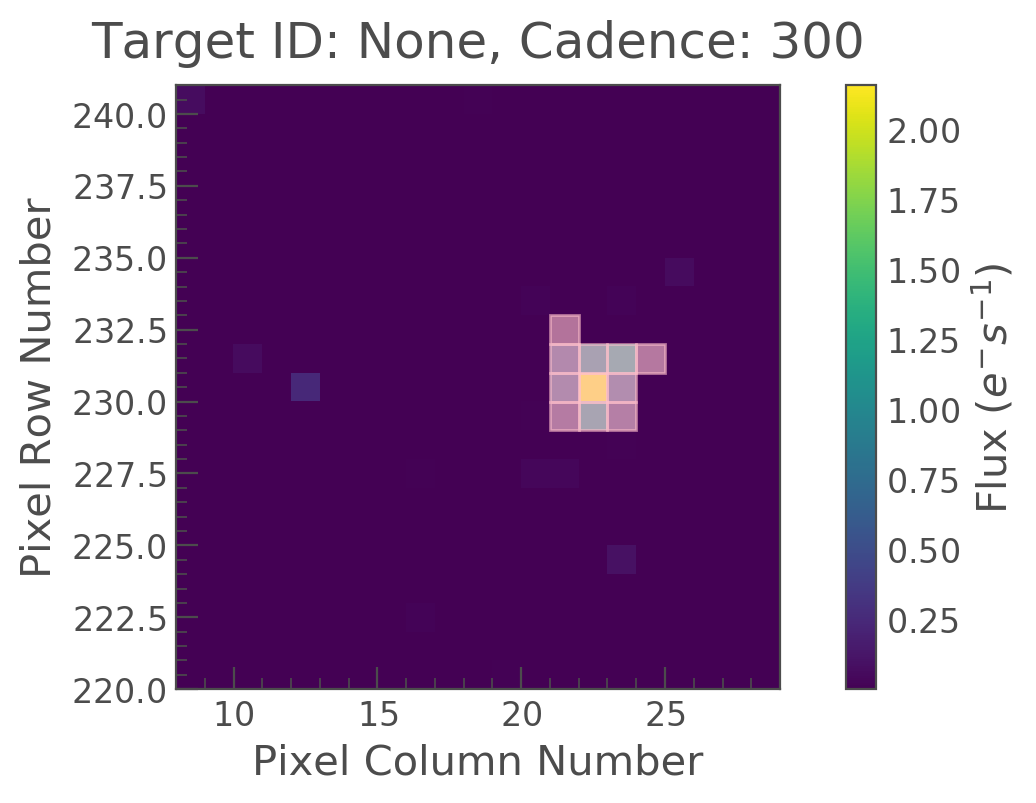

In [26]:
tpf.plot(aperture_mask=aperture_mask, cadenceno=300);

The Spitzer background is highly structure in time.  We can estimate the background locally, and subtract it off.

In [27]:
bkg_aperture = ~tpf.create_threshold_mask(threshold=0.1, reference_pixel=None)

In [28]:
bkg_lc = tpf.to_lightcurve(aperture_mask=bkg_aperture)

In [29]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)

In [30]:
corr_lc = lc - bkg_lc.flux /bkg_aperture.sum()*aperture_mask.sum()

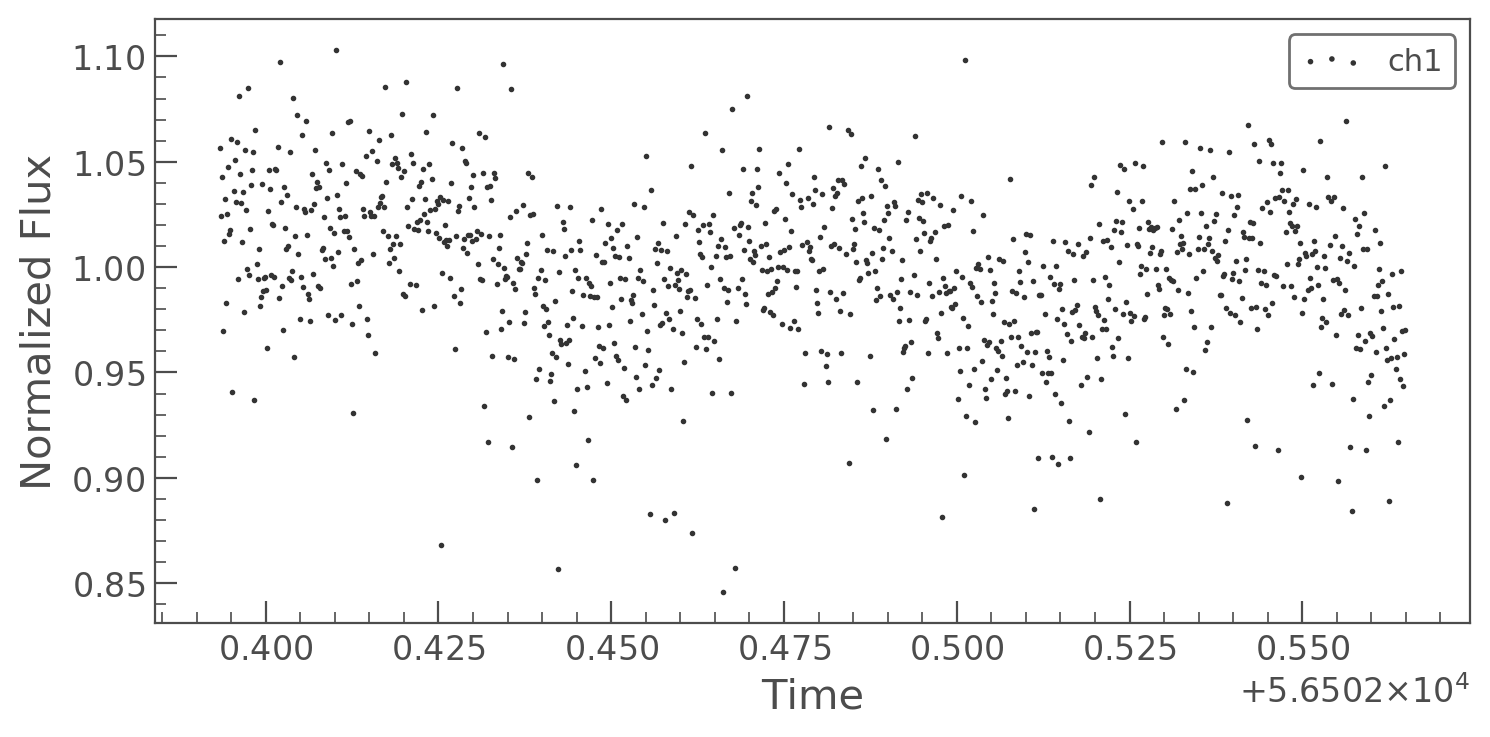

In [31]:
corr_lc.normalize().remove_outliers().scatter()

Compute the periodogram.  

In [42]:
period_bins = np.linspace(0.01, 1, num=5000)
pg = lc.to_periodogram(period=period_bins)

The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.


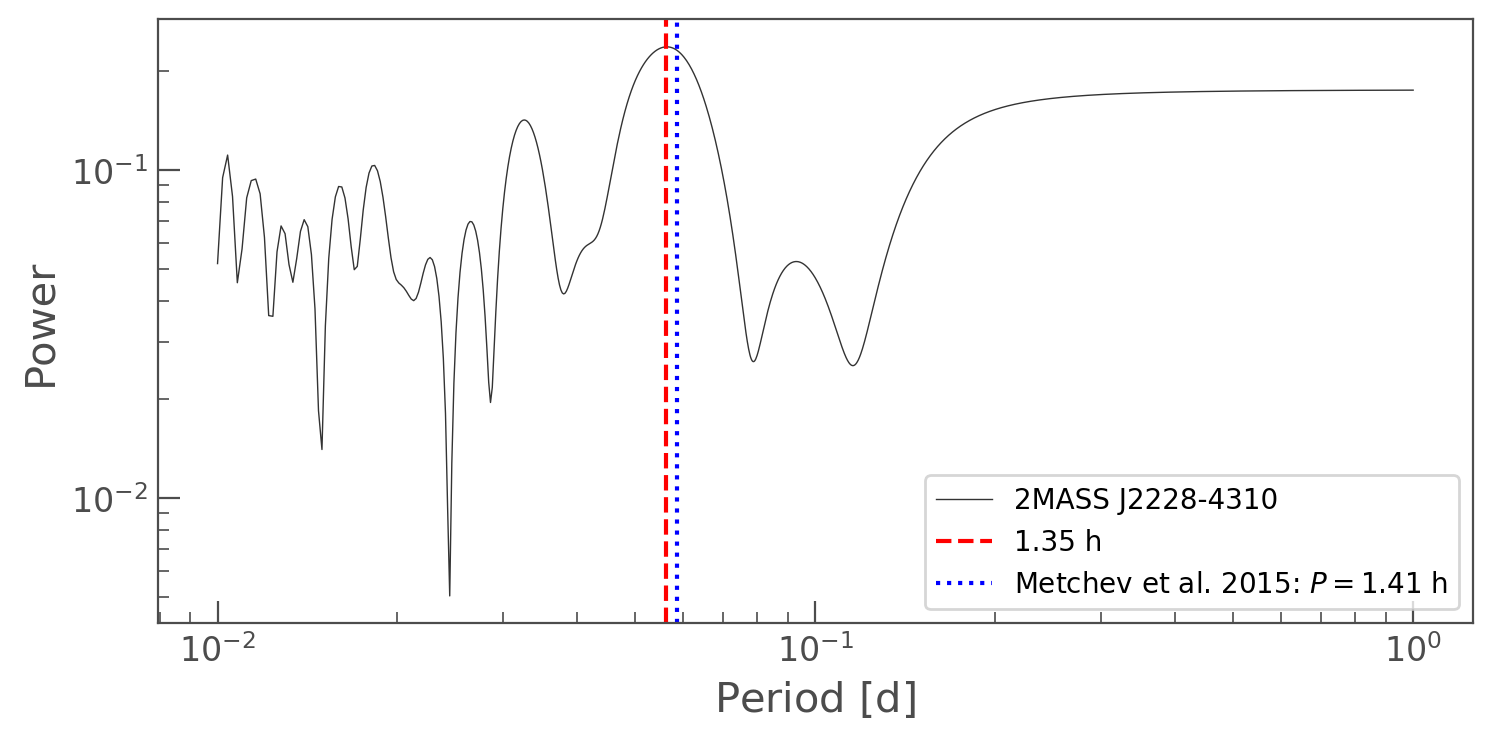

In [43]:
ax = pg.plot(scale='log', label='2MASS J2228-4310')
ax.axvline(pg.period_at_max_power.value, color='r', linestyle='dashed', 
           label="{:0.2f} h".format(pg.period_at_max_power.to(u.hour).value))
ax.axvline((1.41*u.hour).to(u.day).value, color='b', linestyle='dotted', 
           label="Metchev et al. 2015: $P=1.41$ h")
ax.legend();

We find an extremely fast rotation period of $\sim1.35$ h for this brown dwarf, similar to the published value of $P=1.41$ hours from Metchev et al. 2015.